In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler

## HP Rankings

In [9]:
# Load HP data
hp_df = pd.read_csv('../Week3/HP/team_stats.csv')

# Filter for relevant teams
relevant_teams = ['Q9', 'OUG', 'SPG', 'XROCK', 'GodL', 'Wolves']

hp_df = hp_df[hp_df['Team'].isin(relevant_teams)].reset_index(drop=True)

# Add win pct column
win_pct = {
    'Q9': 0.538,
    'OUG': 0.800,
    'SPG': 0.333,
    'XROCK': 0.153,
    'GodL': 0.600,
    'Wolves': 0.818,
}

# Multiply 'WinPct' by 100 for percentage format
hp_df['WinPct'] = hp_df['Team'].map(win_pct) * 100

# Select relevant columns
stats = ['RotationWin', 'BreakSuccess', 'ControlSharePct', 'AvgScoreDiff', 'WinPct']

hp_df = hp_df[['Team'] + stats]

hp_df

,Team,RotationWin,BreakSuccess,ControlSharePct,AvgScoreDiff,WinPct
0,Wolves,47.169811,47.916667,34.892739,31.444444,81.8
1,OUG,47.297297,40.298507,32.121749,37.250000,80.0
2,GodL,48.148148,34.782609,30.733333,72.333333,60.0
3,Q9,43.396226,25.000000,25.688705,-12.714286,53.8
4,XROCK,40.000000,21.739130,22.930108,-58.590909,15.3
5,SPG,29.687500,18.000000,21.849415,-10.250000,33.3


In [10]:
# Standardize stats
# stats = ['RotationWin', 'BreakSuccess', 'ControlSharePct', 'AvgScoreDiff', 'WinPct']
scaler = StandardScaler()
hp_scaled = pd.DataFrame(scaler.fit_transform(hp_df[stats]), columns=stats)

# Assign weights
weights = {
    'WinPct': 0.20,
    'ControlSharePct': 0.20,
    'RotationWin': 0.20,
    'BreakSuccess': 0.20,
    'AvgScoreDiff': 0.20
}

# Calculate weighted score
hp_df['HPRanking'] = sum(hp_scaled[stat] * weight for stat, weight in weights.items())

# Sort by WeightedScore
hp_df = hp_df.sort_values(by='HPRanking', ascending=False, ignore_index=True)

hp_rankings = hp_df[['Team', 'HPRanking']].reset_index(drop=True)
print(hp_rankings)

     Team  HPRanking
0  Wolves   1.072551
1     OUG   0.831087
2    GodL   0.694660
3      Q9  -0.300061
4   XROCK  -1.121032
5     SPG  -1.177205


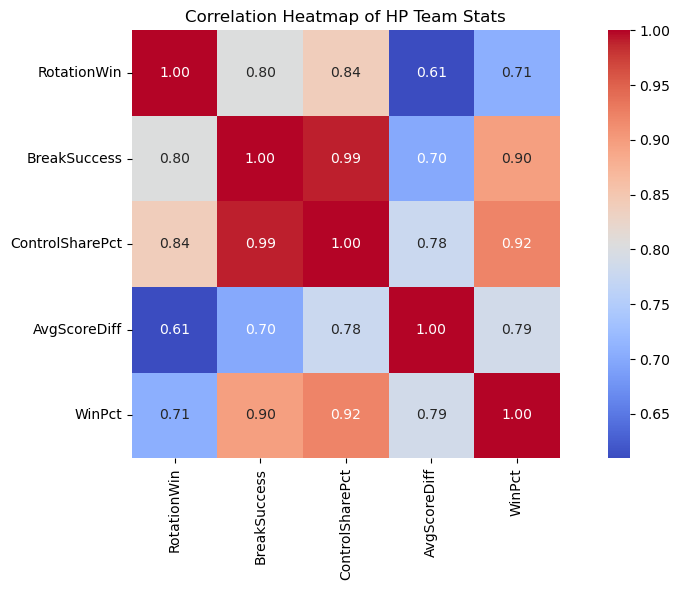

In [11]:
# Correlation between stats and win percentage
correlation_matrix = hp_df[stats].corr()

# Plot heatmap of correlations
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', square=True)
plt.title('Correlation Heatmap of HP Team Stats')
plt.tight_layout()

In [12]:
# Ranking without using WinPct
new_stats = ['RotationWin', 'BreakSuccess', 'ControlSharePct', 'AvgScoreDiff']
scaler = StandardScaler()
new_scaled = pd.DataFrame(scaler.fit_transform(hp_df[new_stats]), columns=new_stats)

# Assign new weights
weights = {
    'ControlSharePct': 0.25,
    'RotationWin': 0.25,
    'BreakSuccess': 0.25,
    'AvgScoreDiff': 0.25
}

# Calculate new weighted score
hp_df['HPRankingNoWinPct'] = sum(new_scaled[stat] * weight for stat, weight in weights.items())

# Sort by new WeightedScore
hp_df = hp_df.sort_values(by='HPRankingNoWinPct', ascending=False, ignore_index=True)
hp_rankings_no_win_pct = hp_df[['Team', 'HPRankingNoWinPct']].reset_index(drop=True)
print(hp_rankings_no_win_pct)

     Team  HPRankingNoWinPct
0  Wolves           1.049553
1    GodL           0.805764
2     OUG           0.766597
3      Q9          -0.372629
4   XROCK          -0.995169
5     SPG          -1.254116


## Control Rankings

In [13]:
import pandas as pd

# Load raw Control rounds (one row per round)
df = pd.read_excel("../Week2/Control/control.xlsx", sheet_name=0)

# Ensure Date is a date (stringify to avoid timezone issues in ID)
df['Date'] = pd.to_datetime(df['Date']).dt.strftime("%Y-%m-%d")

# Build a stable team-pair token (order-free) and a MatchID: Date + Map + Teams
df['TeamPair'] = df.apply(lambda r: " vs ".join(sorted([str(r['Offense']), str(r['Defense'])])), axis=1)
df['MatchID'] = df['Date'] + " | " + df['Map'].astype(str) + " | " + df['TeamPair']

# Count round wins per match per team
round_counts = (
    df.groupby(['MatchID', 'Winner'])
      .size()
      .reset_index(name='RoundWins')
)

# Determine match winner: first to 4 rounds (drop matches with no team reaching 4)
match_winners = (
    round_counts.loc[round_counts.groupby('MatchID')['RoundWins'].idxmax()]
)
match_winners = match_winners[match_winners['RoundWins'] >= 4] \
                             .rename(columns={'Winner': 'MatchWinner'}) \
                             [['MatchID', 'MatchWinner']]

# Find participants for each match
participants = (
    df.groupby('MatchID')
      .apply(lambda g: sorted(set(g['Offense']).union(set(g['Defense']))))
      .reset_index(name='Teams')
)

# Explode to one row per (MatchID, Team)
team_match_rows = participants.explode('Teams').rename(columns={'Teams': 'Team'})

# Games played per team (only include matches that have a decided winner)
decided_matches = team_match_rows[team_match_rows['MatchID'].isin(match_winners['MatchID'])]
games_played = decided_matches.groupby('Team').size().reset_index(name='Games')

# Wins per team: join winners and count when Team == MatchWinner
wins = (
    decided_matches.merge(match_winners, on='MatchID', how='inner')
                   .assign(Win=lambda x: (x['Team'] == x['MatchWinner']).astype(int))
                   .groupby('Team')['Win'].sum()
                   .reset_index(name='Wins')
)

# Win rate = Wins / Games
win_rates = (
    games_played.merge(wins, on='Team', how='left')
                .fillna({'Wins': 0})
                .assign(WinRate=lambda x: x['Wins'] / x['Games'])
                .sort_values(['WinRate', 'Wins', 'Games'], ascending=[False, False, False])
                .reset_index(drop=True)
)

win_rates = win_rates[win_rates['Team'].isin(relevant_teams)].reset_index(drop=True)

win_rates = win_rates[['Team', 'WinRate']]


In [16]:
control_df = pd.read_csv('../Week3/Control/team_summary.csv')
control_df = control_df[control_df['Team'].isin(relevant_teams)].reset_index(drop=True)

control_df = control_df.merge(win_rates, on='Team', how='left')

control_df['AvgTicksAllowedPerDefRound'] = control_df['AvgTicksAllowedPerDefRound'] * (-1)

# Select relevant stats for Control
stats = ['AvgLifeDiff', 'RoundDiff', 'AvgTicksPerOffRound', 'AvgTicksAllowedPerDefRound', 'WinRate']
control_df = control_df[['Team'] + stats]

control_df

,Team,AvgLifeDiff,RoundDiff,AvgTicksPerOffRound,AvgTicksAllowedPerDefRound,WinRate
0,Q9,0.560000,1,3.083333,-3.076923,0.600000
1,Wolves,7.307692,11,3.571429,-2.333333,0.625000
2,SPG,-3.150000,-4,3.000000,-3.200000,0.222222
3,GodL,4.416667,8,3.500000,-2.333333,0.555556
4,OUG,-0.407407,-3,3.846154,-3.285714,0.500000
5,XROCK,-2.166667,-4,3.333333,-4.166667,0.750000


In [17]:
# Standardize stats
# stats = ['AvgLifeDiff', 'RoundDiff', 'AvgTicksPerOffRound', 'AvgTicksAllowedPerDefRound', 'WinRate']
scaler = StandardScaler()
control_scaled = pd.DataFrame(scaler.fit_transform(control_df[stats]), columns=stats)

# Assign weights
weights = {
    'WinRate': 0.20,
    'RoundDiff': 0.20,
    'AvgLifeDiff': 0.20,
    'AvgTicksPerOffRound': 0.20,
    'AvgTicksAllowedPerDefRound': 0.20
}
# Calculate weighted score
control_df['ControlRanking'] = sum(control_scaled[stat] * weight for stat, weight in weights.items())

# Sort by WeightedScore
control_df = control_df.sort_values(by='ControlRanking', ascending=False, ignore_index=True)

control_rankings = control_df[['Team', 'ControlRanking']].reset_index(drop=True)

print(control_rankings)

     Team  ControlRanking
0  Wolves        1.119477
1    GodL        0.726333
2     OUG       -0.038891
3      Q9       -0.189218
4   XROCK       -0.495764
5     SPG       -1.121938


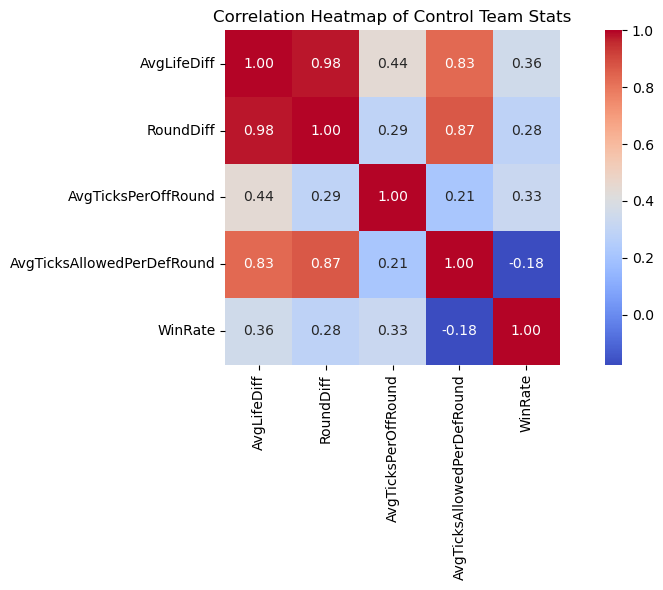

In [18]:
# Correlation between stats and win percentage
correlation_matrix_control = control_df[stats].corr()

# Plot heatmap of correlations
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix_control, annot=True, cmap='coolwarm', fmt='.2f', square=True)
plt.title('Correlation Heatmap of Control Team Stats')
plt.tight_layout()

In [19]:
# Ranking without using WinRate
new_stats = ['AvgLifeDiff', 'RoundDiff', 'AvgTicksPerOffRound', 'AvgTicksAllowedPerDefRound']
scaler = StandardScaler()
new_scaled_control = pd.DataFrame(scaler.fit_transform(control_df[new_stats]), columns=new_stats)

# Assign new weights
weights_control = {
    'RoundDiff': 0.25,
    'AvgLifeDiff': 0.25,
    'AvgTicksPerOffRound': 0.25,
    'AvgTicksAllowedPerDefRound': 0.25
}

# Calculate new weighted score
control_df['ControlRankingNoWinRate'] = sum(new_scaled_control[stat] * weight for stat, weight in weights_control.items())
# Sort by new WeightedScore
control_df = control_df.sort_values(by='ControlRankingNoWinRate', ascending=False, ignore_index=True)
control_rankings_no_win_rate = control_df[['Team', 'ControlRankingNoWinRate']].reset_index(drop=True)
print(control_rankings_no_win_rate)

     Team  ControlRankingNoWinRate
0  Wolves                 1.271565
1    GodL                 0.887214
2     OUG                 0.016347
3      Q9                -0.325755
4     SPG                -0.909143
5   XROCK                -0.940229


## SnD Rankings

In [12]:
# Load the data
snd_df = pd.read_csv('../rankings/snd_stats.csv')

# Filter for relevant teams
snd_df = snd_df[snd_df['Team'].isin(relevant_teams)].reset_index(drop=True)

# Add win pct column
win_pct = {
    'Q9': 0.73,
    'OUG': 0.38,
    'SPG': 0.57,
    'XROCK': 0.42,
    'GodL': 0.50,
    'Wolves': 0.58,
}

# Multiply 'WinPct' by 100 for percentage format
snd_df['WinPct'] = snd_df['Team'].map(win_pct) * 100

snd_df

,Team,PlantRate,RetakeRate,RoundDiff,FBRate,WinPct
0,GodL,50.000000,28.947368,4,46.052632,50.0
1,OUG,57.281553,30.000000,-14,46.330275,38.0
2,Q9,58.064516,35.897436,25,48.087432,73.0
3,SPG,61.417323,16.666667,16,50.000000,57.0
4,Wolves,42.477876,34.482759,6,55.963303,58.0
5,XROCK,43.820225,23.529412,-16,53.333333,42.0


In [13]:
# Standardize stats
stats = ['WinPct', 'PlantRate', 'RetakeRate', 'RoundDiff', 'FBRate']
scaler = StandardScaler()
snd_scaled = pd.DataFrame(scaler.fit_transform(snd_df[stats]), columns=stats)

# Assign weights
weights = {
    'WinPct': 0.20,
    'PlantRate': 0.20,
    'RetakeRate': 0.20,
    'RoundDiff': 0.20,
    'FBRate': 0.20
}
# Calculate weighted score
snd_df['SNDRanking'] = sum(snd_scaled[stat] * weight for stat, weight in weights.items())

# Sort by WeightedScore
snd_df = snd_df.sort_values(by='SNDRanking', ascending=False, ignore_index=True)
snd_rankings = snd_df[['Team', 'SNDRanking']].reset_index(drop=True)
print(snd_rankings)

     Team  SNDRanking
0      Q9    0.931090
1  Wolves    0.373090
2     SPG    0.141984
3    GodL   -0.299191
4     OUG   -0.502573
5   XROCK   -0.644399


## Combine Rankings

In [14]:
# Combine rankings into a single DataFrame
combined_rankings = (
    hp_rankings.merge(control_rankings, on='Team', how='outer')
               .merge(snd_rankings, on='Team', how='outer')
)

# Define weights for each ranking
final_weights = {
    'HPRanking': 0.40,
    'ControlRanking': 0.20,
    'SNDRanking': 0.40
}
# Calculate final ranking
combined_rankings['FinalRanking'] = sum(combined_rankings[stat] * weight for stat, weight in final_weights.items())

# Normalize FinalRanking to 50-100 scale
min_rank = combined_rankings['FinalRanking'].min()
max_rank = combined_rankings['FinalRanking'].max()
combined_rankings['FinalRanking'] = 50 + (combined_rankings['FinalRanking'] - min_rank) / (max_rank - min_rank) * 50

# Sort by FinalRanking
combined_rankings = combined_rankings.sort_values(by='FinalRanking', ascending=False, ignore_index=True)

print(combined_rankings)

     Team  HPRanking  ControlRanking  SNDRanking  FinalRanking
0  Wolves   1.013763        0.113495    0.373090    100.000000
1      Q9  -0.203844        0.174914    0.931090     90.709725
2     OUG   0.764408        1.015139   -0.502573     90.040550
3    GodL   0.637200        0.102229   -0.299191     84.422906
4   XROCK  -0.980783        0.298911   -0.644399     56.874717
5     SPG  -1.230744       -1.704687    0.141984     50.000000


In [100]:
combined_rankings.to_csv('../rankings/final_team_rankings.csv', index=False)